# Lost Rhino

In this notebook, we plot **Figures 1(a) and 1(b)**. To do so, we need to get the ratings for the particular beer called *Lost Rhino* from the brewery *Lost Rhino Ice Breaker*.

**Requirements**:
- You need to run notebook `4-zscores` to get the file `z_score_params_matched_ratings` in `data/tmp` and the files `ratings_ba.txt.gz` and `ratings_rb.txt.gz` in `data/matched`. In other words, you need to **run the first 5 cells of `4-zscores`**.

**Benchmark time**: This notebook has been run on a Dell Latitude (ElementaryOS 0.4.1 Loki, i7-7600U, 16GB RAM).

In [1]:
import os
os.chdir('..')

In [2]:
# Helpers functions
from python.helpers import parse

# Libraries for preparing data
import json
import gzip
import numpy as np
import pandas as pd
from datetime import datetime

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib

# Folders
data_folder = '../data/'
fig_folder = '../figures/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# General info for plotting
colors = {'ba': (232/255,164/255,29/255), 
          'rb': (0/255,152/255,205/255)}

labels = {'ba': 'BeerAdvocate', 'rb': 'RateBeer'}

# Check that folders exist
if not os.path.exists(data_folder + 'tmp'):
    os.makedirs(data_folder + 'tmp')

if not os.path.exists(data_folder + 'prepared'):
    os.makedirs(data_folder + 'prepared')
    
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Prepare the data

We simply need to get all the ratings of the beers *Lost Rhino* in order.

In [3]:
%%time

with open('../data/tmp/z_score_params_matched_ratings.json') as file:
    z_score_params = json.load(file)

lost_rhino = {'ba': [], 'rb': []}
lost_rhino_dates = {'ba': [], 'rb': []}
id_ = {'ba': 78599, 'rb': 166120}

# Go through RB and BA
for key in ['ba', 'rb']:
    print('Parsing {} reviews.'.format(key.upper()))
    
    # Get the iterator with the ratings fo the matched beers
    gen = parse(data_folder + 'matched/ratings_{}.txt.gz'.format(key))
    
    # Go through the iterator
    for item in gen:
        
        if int(item['beer_id']) == id_[key]:
            
            # Get the year
            date = int(item['date'])
            year = str(datetime.fromtimestamp(date).year)
            
            # Get the rating
            rat = float(item['rating'])
        
            # Compute its zscore based on the year
            zs = (rat-z_score_params[key][year]['mean'])/z_score_params[key][year]['std']
            
            # Add date and zscore
            lost_rhino_dates[key].append(date)
            lost_rhino[key].append(zs)
            
for key in lost_rhino.keys():
    # Get the sorted dates from smallest to biggest
    idx = np.argsort(lost_rhino_dates[key])
    # Sort the zscores for lost_rhino
    lost_rhino_dates[key] = list(np.array(lost_rhino_dates[key])[idx])
    lost_rhino[key] = list(np.array(lost_rhino[key])[idx])
    
with open(data_folder + 'prepared/lost_rhino.json', 'w') as outfile:
    json.dump(lost_rhino, outfile)

Parsing BA reviews.
Parsing RB reviews.
CPU times: user 1min 50s, sys: 392 ms, total: 1min 50s
Wall time: 1min 52s


## Plot the ratings of the *Lost Rhino*

The first cell plots each ratings and the second cell plots the running mean.

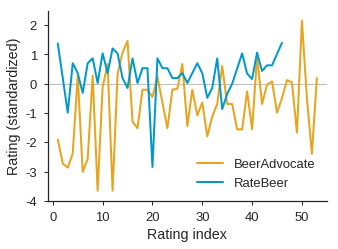

In [4]:
with open(data_folder + 'prepared/lost_rhino.json', 'r') as infile:
    ratings = json.load(infile)
    
plt.figure(figsize=(5, 3.5), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot([-10, 55], [0, 0], 'grey', linewidth=0.5)

for key in ['ba', 'rb']:

    rats = ratings[key]

    rmean = np.cumsum(rats)/np.array(range(1, len(rats)+1))

    ax.plot(list(range(1, len(rmean)+1)), rats, color=colors[key], label=labels[key], linewidth=2)
    
plt.xlim([-1, 55])
plt.ylim([-4, 2.5])
plt.yticks(list(range(-4, 3)), list(range(-4, 3)))


plt.ylabel('Rating (standardized)')
plt.xlabel('Rating index')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig(fig_folder + 'timeseries_zscore_example.pdf', bbox_inches='tight')

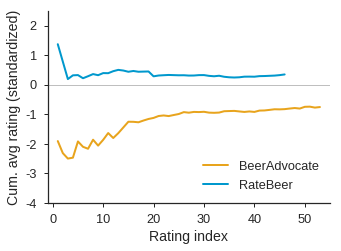

In [5]:
with open(data_folder + 'prepared/lost_rhino.json', 'r') as infile:
    ratings = json.load(infile)
    

plt.figure(figsize=(5, 3.75), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.28)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot([-10, 55], [0, 0], 'grey', linewidth=0.5)

for key in ['ba', 'rb']:
    
    rats = ratings[key]

    rmean = np.cumsum(rats)/np.array(range(1, len(rats)+1))

    ax.plot(list(range(1, len(rmean)+1)), rmean, color=colors[key], label=labels[key], linewidth=2)

plt.ylabel('Cum. avg rating (standardized)')
plt.xlabel('Rating index')

plt.xlim([-1, 55])
plt.ylim([-4, 2.5])
plt.yticks(list(range(-4, 3)), list(range(-4, 3)))

leg = plt.legend(loc=4)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

plt.savefig(fig_folder + 'timeseries_avg_zscore_example.pdf', bbox_inches='tight')